In [1]:
# imports
import pathlib, pickle
from io import BytesIO
from PIL import Image
import sqlalchemy as sqa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow
from IPython.display import Image as display_image

In [2]:
# read the credentials from the pickle file
db_auth_pkl_file_path = pathlib.Path("/home/neminiz1/flyer_analysis_db_auth.pkl")
with open(db_auth_pkl_file_path, "rb") as fp:
    auth = pickle.load(fp)

# connect to the database with an engine and reflect it onto a metadata object
db_connection_string = (
    f"mssql+pymssql://{auth['username']}:{auth['password']}"
    f"@{auth['ip_address']}:{auth['port']}/{auth['db_name']}?charset=utf8"
)
engine = sqa.create_engine(db_connection_string)  # ,echo=True)
meta = sqa.MetaData()
meta.reflect(bind=engine)

### Find all of the tables in the DB and each table's column names

In [3]:
for table in meta.tables:
    print(f"-------{table} table----------")
    table_pks = [
        key.name for key in sqa.inspection.inspect(meta.tables[table]).primary_key
    ]
    for column in meta.tables[table].columns:
        prepend = "PRIMARY KEY: " if column.name in table_pks else ""
        foreign_keys = [
            f"FK: {key.target_fullname}"
            for key in meta.tables[table].columns[column.name].foreign_keys
        ]
        append = f" ({','.join(foreign_keys)})" if len(foreign_keys) > 0 else ""
        print(f"\t{prepend}{column}{append}")

-------epoxy table----------
	epoxy.epoxy_id
	PRIMARY KEY: epoxy.epoxy_name
	epoxy.description
	epoxy.epoxy_supplier
	epoxy.recordid
-------experiment table----------
	experiment.performed_by
	experiment.date
	experiment.energy
	experiment.theoretical_beam_diameter
	experiment.fluence
	experiment.beam_shaper_input_beam_diameter
	experiment.beam_shaper
	experiment.effective_focal_length
	experiment.drive_laser_mode
	experiment.oscillator_setting
	experiment.amplifier_setting
	experiment.attenuator_angle
	experiment.new_energy_measurement
	experiment.booster_amp_setting
	experiment.preamp_output_power
	experiment.pdv_spot_size
	experiment.focusing_lens_arrangement
	experiment.system_configuration
	experiment.current_set_point
	experiment.oscilloscope_range
	experiment.pdv_method
	experiment.seed_laser_wavelength
	experiment.reference_laser_wavelength
	experiment.time_per_div
	experiment.carrier_freq
	experiment.camera_lens
	experiment.doubler
	experiment.camera_aperture
	experiment.lens_

### Plotting the dates of every experiment

In [4]:
with engine.connect() as conn:
    min_date = conn.execute(sqa.text("SELECT MIN(date) FROM experiment")).first()[0]

with engine.connect() as conn:
    max_date = conn.execute(sqa.text("SELECT MAX(date) FROM experiment")).first()[0]

with engine.connect() as conn:
    results = conn.execute(sqa.text("SELECT date, performed_by FROM experiment")).all()

In [5]:
experiment_dates_for_performer = {}
for res in results:
    if res.performed_by not in experiment_dates_for_performer:
        experiment_dates_for_performer[res.performed_by] = []
    experiment_dates_for_performer[res.performed_by].append(res.date)

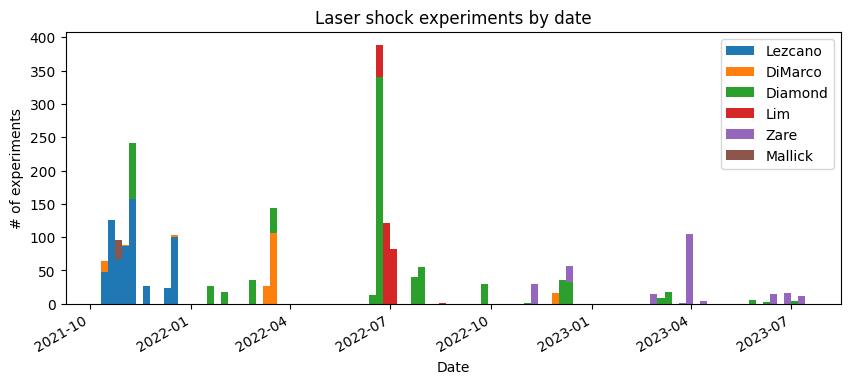

In [6]:
f, ax = plt.subplots(figsize=(10.0, 4.0))
ax.hist(
    experiment_dates_for_performer.values(),
    bins=100,
    range=(min_date, max_date),
    label=list(experiment_dates_for_performer.keys()),
    stacked=True,
)
ax.legend(loc="best")
ax.set_xlabel("Date")
ax.set_ylabel("# of experiments")
ax.set_title("Laser shock experiments by date")
f.autofmt_xdate()
plt.show()

### Getting the numbers of experiments performed on each sample and their date ranges

In [7]:
query = """
    SELECT experiment.date, sample.sample_name
    FROM experiment
    JOIN launch_package ON experiment.launch_id = launch_package.launch_id
    JOIN sample ON launch_package.sample_name = sample.sample_name
"""

with engine.connect() as conn:
    results = conn.execute(sqa.text(query)).all()

In [8]:
experiment_dates_for_sample = {}
for res in results:
    if res.sample_name not in experiment_dates_for_sample:
        experiment_dates_for_sample[res.sample_name] = []
    experiment_dates_for_sample[res.sample_name].append(res.date)

In [9]:
display_df = pd.DataFrame.from_dict(
    {
        "sample name": list(experiment_dates_for_sample.keys()),
        "earliest experiment": [
            min(exp_date_list) for exp_date_list in experiment_dates_for_sample.values()
        ],
        "latest experiment": [
            max(exp_date_list) for exp_date_list in experiment_dates_for_sample.values()
        ],
    }
)

display_df.sort_values("earliest experiment", inplace=True)

print(display_df.to_string())

                               sample name earliest experiment latest experiment
2             20-26 Mg-6Al 4Bc ECAE Billet          2021-10-13        2021-10-20
3             20-25 Mg-6Al 4Bc ECAE Billet          2021-10-19        2021-10-21
1              22-04 Mg-6Al 4Bc ECAE Plate          2021-10-21        2021-11-12
8                           Suhas20211027A          2021-10-28        2022-03-18
9                           Suhas20211027B          2021-10-28        2022-03-18
10                          Suhas20211027C          2021-10-28        2021-10-28
11                          Suhas20211027D          2021-10-28        2021-10-28
6          22-17 Mg-6Al 1Bc+3Bc ECAE Plate          2021-11-03        2021-11-12
7              23-03 Mg-9Al 4Bc ECAE Plate          2021-11-03        2021-11-12
12     Jenna Sample1 MgZnCa ECAE 5um grain          2021-11-09        2022-01-28
5     Jenna Sample2 MgZnCa ECAE 20um grain          2021-11-11        2022-06-22
16             Lexan 8010 12

### Finding the experiments that have video analysis data

In [10]:
query = """
    SELECT exp.experiment_type, exp.date, ml.experiment_day_counter, ml.camera_filename
    FROM experiment AS exp
    JOIN metadata_links AS ml
    ON exp.video_metadata_link_ID = ml.ID
    WHERE exp.video_metadata_link_ID IS NOT NULL
"""

with engine.connect() as conn:
    results_df = pd.read_sql(sqa.text(query),conn)

print(results_df.to_string())

             experiment_type       date experiment_day_counter camera_filename
0    Flyer velocity analysis 2023-06-16                  00000            None
1    Flyer velocity analysis 2023-06-16                  00001            None
2                      Spall 2021-11-09                   None        21_19_38
3                      Spall 2021-12-17                   None        14_05_23
4    Flyer velocity analysis 2022-03-10                   None        11_31_51
5    Flyer velocity analysis 2022-03-10                   None        11_59_17
6    Flyer velocity analysis 2022-03-10                   None        12_04_06
7    Flyer velocity analysis 2022-03-10                   None        13_40_01
8    Flyer velocity analysis 2022-03-10                   None        13_43_50
9    Flyer velocity analysis 2022-03-10                   None        13_47_12
10   Flyer velocity analysis 2022-03-10                   None        13_50_21
11   Flyer velocity analysis 2022-03-10             

### Find Flyer Velocity Analysis experiments with good quality videos and make an example gif

In [11]:
query = """
    SELECT exp.recordID, exp.date, ml.experiment_day_counter, ml.camera_filename, ml.ID
    FROM experiment AS exp
    JOIN metadata_links AS ml
    ON exp.video_metadata_link_ID = ml.ID
    WHERE exp.video_metadata_link_ID IS NOT NULL
    AND exp.experiment_type = 'Flyer velocity analysis'
    AND exp.video_quality = 'Great'
"""

with engine.connect() as conn:
    results_df = pd.read_sql(sqa.text(query),conn)

print(results_df.to_string())

   recordID       date experiment_day_counter camera_filename   ID
0       936 2022-03-10                   None        13_47_12   13
1       937 2022-03-10                   None        13_50_21   14
2       938 2022-03-10                   None        14_22_56   15
3       939 2022-03-10                   None        14_26_39   16
4       940 2022-03-10                   None        14_30_10   17
5       941 2022-03-10                   None        14_32_28   18
6       942 2022-03-10                   None        14_36_40   19
7       945 2022-03-10                   None        14_42_49   20
8      1026 2022-03-18                   None        15_55_43   64
9      1027 2022-03-18                   None        16_01_25   65
10     1031 2022-03-18                   None        17_15_49   69
11     1032 2022-03-18                   None        17_45_34   70
12     1039 2022-03-18                   None        19_49_09   77
13     1131 2022-06-20                  00012            None 

In [12]:
EXAMPLE_VIDEO_LINK_ID = 70 # choose from the "ID" column in the output of the cell above

query = f"""
    SELECT far.rel_filepath, far.center_column, far.center_row, flyer_ims.camera_image, flyer_ims.analysis_image
    FROM flyer_analysis_results AS far
    JOIN flyer_images AS flyer_ims
    ON flyer_ims.analysis_result_ID = far.ID
    WHERE far.metadata_link_ID = {EXAMPLE_VIDEO_LINK_ID}
    ORDER BY far.rel_filepath
"""

with engine.connect() as conn:
    results = conn.execute(sqa.text(query)).all()

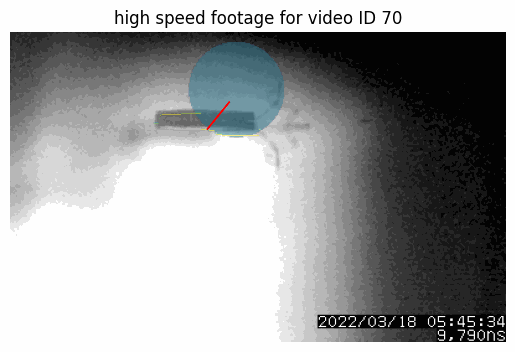

In [13]:
# frames on which the gif should start and end
START_FRAME = 90
END_FRAME = 270

gif_title = f"high speed footage for video ID {EXAMPLE_VIDEO_LINK_ID}"

gif_frame_bytestrings = []
for result in results:
    # skip any "TC" images
    if pathlib.Path(result.rel_filepath).name.startswith("TC--"):
        continue
    # get the frame number and make sure it's in range
    frame_number = int(
        result.rel_filepath.split("/")[-1].split("_")[-1][: -len(".bmp")]
    )
    if frame_number not in range(START_FRAME, END_FRAME + 1):
        continue
    # convert the original image to a numpy array
    original_image = np.asarray(Image.open(BytesIO(result.camera_image)))
    # if the frame didn't have a good result, just use the original grayscale image
    if result.analysis_image is None:
        frame_stream = BytesIO()
        f, ax = plt.subplots()
        ax.imshow(original_image, cmap="gray")
        ax.set_title(gif_title)
        ax.axis("off")
        plt.savefig(frame_stream, bbox_inches="tight")
        plt.close()
        frame_stream.seek(0)
        gif_frame_bytestrings.append(frame_stream.read())
        continue
    # if the result was good, though, create an overlay from the result
    analysis_image = np.load(BytesIO(result.analysis_image))["arr_0"]
    flyer_row, flyer_col = np.nonzero(np.where(analysis_image > 200, 1, 0))
    analysis_overlay = np.zeros_like(original_image)
    analysis_overlay[: analysis_image.shape[0], :] = analysis_image
    arrow = FancyArrow(
        np.median(flyer_col),
        np.median(flyer_row),
        0.75 * (result.center_column - np.mean(flyer_col)),
        0.75 * (result.center_row - np.mean(flyer_row)),
        width=0.1,
        color="r",
    )
    frame_stream = BytesIO()
    f, ax = plt.subplots()
    ax.imshow(original_image, cmap="gray")
    analysis_im_alphas = 0.5 * np.ones_like(analysis_overlay)
    analysis_im_alphas[analysis_overlay == 0] = 0
    ax.imshow(analysis_overlay, alpha=analysis_im_alphas)
    ax.add_patch(arrow)
    ax.set_title(gif_title)
    ax.axis("off")
    plt.savefig(frame_stream, bbox_inches="tight")
    plt.close()
    frame_stream.seek(0)
    gif_frame_bytestrings.append(frame_stream.read())
gif_stream = BytesIO()
gif_frames = [
    Image.open(BytesIO(frame_bytestring))
    for frame_bytestring in gif_frame_bytestrings
]
frame_one = gif_frames[0]
frame_one.save(
    gif_stream,
    format="GIF",
    append_images=gif_frames,
    save_all=True,
    duration=100,
    loop=0,
)
gif_stream.seek(0)
display(display_image(data=gif_stream.read()))